# Random forest

Семинар основан на <a href="https://habr.com/en/company/ods/blog/324402/">материале</a> ODS

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.special import binom
from IPython.display import Image
from matplotlib import pyplot as plt

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits as load
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

%matplotlib inline

/Users/maxim/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


----------

## Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных. 
- $\large N $ — количество присяжных
- $\large p $ — вероятность правильного решения присяжного
- $\large \mu $ — вероятность правильного решения всего жюри
- $\large m $ — минимальное большинство членов жюри, $ m = floor(N/2) + 1 $
- $\large C_N^i$ — число [сочетаний](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D1%87%D0%B5%D1%82%D0%B0%D0%BD%D0%B8%D0%B5) из $N$ по $i$
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
Если $\large p > 0 $, то $\large \mu > p $
Если $\large N \rightarrow \infty $, то $\large \mu \rightarrow 1 $

In [3]:
def ensemble_acc(p, n):
    m = n//2 + 1
    return np.sum([binom(n, i) * p**i * (1 - p)**(n - i) for i in range(m, n + 1)])

In [4]:
n = 3
p = 0.7
print("Вероятность правильного ответа у n = {} присяжных, если каждый отвечает правильно с вероятностью p = {}, равна {:.3f}".format(
    n, p, ensemble_acc(p, n)
))

Вероятность правильного ответа у n = 3 присяжных, если каждый отвечает правильно с вероятностью p = 0.7, равна 0.784


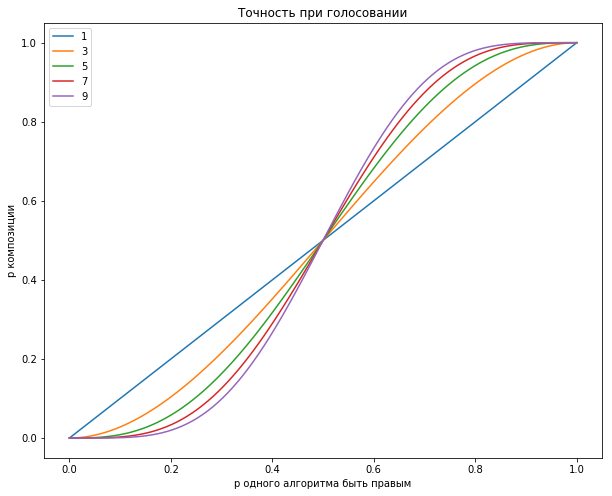

In [5]:
p = np.linspace(0, 1, 100).reshape((-1, 1))

plt.figure(figsize=(10, 8))
for i in range(1, 10, 2):
    plt.plot(p, np.apply_along_axis(ensemble_acc, 1, p, i), label="{}".format(i))

plt.title("Точность при голосовании")
plt.xlabel("p одного алгоритма быть правым")
plt.ylabel("p композиции")
plt.legend()
plt.show()

----------

## Bootstrap

<img src='img/bootstrap.png'>

** Важно! **
    - Бутстрепная выборка имеет такой же размер, что и исходная
    - Генерация с повторениями

----------

## BAGGING(Bootstrap AGGregetING)

## $$a_{Bagging}(x) = \frac{1}{M}\sum_{i=1}^M b_i(x)$$

$b_i(x)$ - обучен на бутстреп-выборке $X^i$

<img src='img/bagging.png'>

In [6]:
iris = load()
X = iris.data
y = iris.target

Качество классификации одним решающим деревом:

In [7]:
d3 = DecisionTreeClassifier() # Обычное решающее дерево

print("Decision tree:", cross_val_score(d3, X, y).mean())

Decision tree: 0.7702658855778631


Качество бэггинга над решающими деревьями:

In [8]:
print("Bagging:", cross_val_score(BaggingClassifier(d3), X, y).mean())

Bagging: 0.8892772238528509


- Какой недостаток есть у деревьев?
- Как bagging борется с этим недостатком?
- Как можно улучшить качество?

Теперь при построении каждого узла будем отбирать случайные max_features признаков и искать информативное разбиение только по одному из них:

In [9]:
f = X.shape[1]
rnd_d3 = DecisionTreeClassifier(max_features=int(f ** 0.5)) # Решающее дерево с рандомизацией в сплитах

print("Randomized Bagging:", cross_val_score(BaggingClassifier(rnd_d3), X, y).mean())

Randomized Bagging: 0.9064895966435471


----------

## Random Forest

<img src='img/forest.jpeg' width=700>

##### Алгоритм построения случайного леса из $N$ деревьев

Для каждого $n = 1..N$:

Сгенерировать выборку $X_n$ с помощью бутстрэпа;
Построить решающее дерево $b_n$ по выборке $X_n$:
    1. по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
    2. дерево строится, пока в каждом листе не более $n_{min}$ объектов или пока не достигнем определенной высоты дерева
    3. при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, и оптимальное разделение выборки ищется только среди них.

Итоговый классификатор:
    $$ a(x) = \dfrac{1}{N} \sum_{i=1}^{N} b_i(x)$$

$m$ советуют выбирать равным:
- $\sqrt{n}$ для классификации
- $\dfrac{n}{3}$ для регрессии

----------

## Hand made Random Forest

**Необходимо реализовать класс `RandomForest`** (для решения задачи классификации)

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    - `num_trees` - количество деревьев в лесе;
    - `max_depth` - максимальная глубина дерева (по умолчанию - `None`); 
    - `max_features` - количество признаков, принимаемое к рассмотрению при разбиении (аналогичный параметр есть в sklearn имплементации) (по умолчанию - `None`); 
    - `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', по умолчанию - 'gini'); 
    
- класс имеет методы `fit` и `predict`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `RandomForest`, представляющий собой Random Forest, обученный по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов;

In [10]:
def bootstrap(X, y, size):
    # Implement random sampling here
    sample_X, sample_y = <ваш код>
    return sample_X, sample_y

In [11]:
class RandomForest:
    def __init__(self, num_trees, max_depth=None, max_features=None, criterion='gini'):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []
    
    def fit(self, X_train, y_train):
        '''
        Create trees here, using bootstrap.
        '''
        <ваш код>
            
        return self
    
    def predict(self, X_test):
        '''
        Predict the label here using your grown trees.
        '''
        y_pred = np.zeros(X_test.shape[0])
        <ваш код>
        
        return y_pred

#### Тестирование

Разделим датасет ирисов на обучающую и тестовую выборку

In [12]:
iris = load()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучим наш Random Forest

In [13]:
num_trees = 10
max_depth = 10
max_features = 'sqrt'
criterion = 'gini'

clf = RandomForest(num_trees=num_trees, max_depth=max_depth, max_features=max_features, criterion=criterion)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [14]:
accuracy_score(y_pred, y_test)

0.9444444444444444

Обучим DecisionTreeClassifier

In [15]:
max_depth = 10
max_features = None
criterion = 'gini'

clf = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
accuracy_score(y_pred, y_test)

0.85

----------

## Bias-Variance Tradeoff

####  Разложение ошибки на Bias и Variance

<img src='img/bv_darts.png' width=400>

#### Как это отражается на модели

<img src='img/bias-variance-tradeoff.png' width=550>


<img src='img/bv_model_complex.png' width=550>

----------

## Bias-Variance tradeoff для Bagging

Рассмотрим задачу регрессии с базовыми алгоритмами $b_1(x), .. ,b_n(x)$. Предположим, что существует истинная функция ответа для всех объектов $y(x)$, а также задано распределение на объектах $p(x)$. В этом случае мы можем записать ошибку каждой функции регрессии:

$$\varepsilon_i(x) = b_i(x) - y(x), i=1,..,n$$

Средняя ошибка построенных функций регрессии имеет вид:
    $$E_1 = \dfrac{1}{n} E_x \varepsilon_i^2(x)$$

Предположим, что ошибки несмещены и некоррелированы:
    $$E_x \varepsilon_i(x) = 0$$
    $$E_x \varepsilon_i(x) \varepsilon_j(x) = 0, i \neq j$$

Построим теперь новую функцию регрессии, которая будет усреднять ответы построенных нами функций:
    $$a(x) = \dfrac{1}{n} \sum_{i=1}^n b_i(x)$$

Найдем ее среднеквадратичную ошибку:

<center><img src="img/bv_6.png"></center>

## Есть ли переобучение с увеличением числа деревьев?

In [17]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9972164231036882 test_acc = 0.9305555555555556
n_estimators =   40 train_acc =  1.0 test_acc = 0.9361111111111111
n_estimators =  100 train_acc =  1.0 test_acc = 0.95
n_estimators =  200 train_acc =  1.0 test_acc = 0.9472222222222222
n_estimators =  600 train_acc =  1.0 test_acc = 0.9527777777777777
n_estimators = 1000 train_acc =  1.0 test_acc = 0.9527777777777777
CPU times: user 2.23 s, sys: 1.18 s, total: 3.41 s
Wall time: 20.6 s


In [18]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9638135003479471 test_acc = 0.9194444444444444
n_estimators =   40 train_acc = 0.9693806541405706 test_acc = 0.9111111111111111
n_estimators =  100 train_acc = 0.9665970772442589 test_acc = 0.9166666666666666
n_estimators =  200 train_acc = 0.9679888656924147 test_acc = 0.9138888888888889
n_estimators =  600 train_acc = 0.9659011830201809 test_acc = 0.9222222222222223
n_estimators = 1000 train_acc = 0.9686847599164927 test_acc = 0.9138888888888889
CPU times: user 2.11 s, sys: 989 ms, total: 3.1 s
Wall time: 17.5 s


In [19]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.9986082115518441 test_acc = 0.925
n_estimators =   40 train_acc =  1.0 test_acc = 0.9388888888888889
n_estimators =  100 train_acc =  1.0 test_acc = 0.9527777777777777
n_estimators =  200 train_acc =  1.0 test_acc = 0.9305555555555556
n_estimators =  600 train_acc =  1.0 test_acc = 0.9472222222222222
n_estimators = 1000 train_acc =  1.0 test_acc = 0.9444444444444444
CPU times: user 2.15 s, sys: 1.22 s, total: 3.37 s
Wall time: 18.9 s


<h1 align="center">Выводы</h1> 

**Bagging**:
    - Одна из лучших техник для построения алгоритмов ML
    - Линейно уменьшает разброс и не уменьшает смещение (если не коррелированы ответы базовых алоритмов) 
    - Слабое переобучение
    - НО переобучение ЕСТЬ -- от сложности одного алгоритма, лучше все же немного обрезать деревья

** Random Forest **

Плюсы:
- имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
- практически не чувствителен к выбросам в данных из-за случайного сэмлирования
- не чувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
- не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
- способен эффективно обрабатывать данные с большим числом признаков и классов
- одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
- редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
- для случайного леса существуют методы оценивания значимости отдельных признаков в модели
- хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
- предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
- вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
- возможности, описанные выше, могут быть расширены до неразмеченных данных, что приводит к возможности делать кластеризацию и визуализацию данных, обнаруживать выбросы
- высокая параллелизуемость и масштабируемость.

Минусы:
- в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
- нет формальных выводов (p-values), доступных для оценки важности переменных
- алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
- случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
- алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
- для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокое значение оптимизируемого функционала (типа прироста информации)
- если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
- больший размер получающихся моделей. Требуется $O(NK)$ памяти для хранения модели, где $K$ — число деревьев.